# SONAR DATA

The file "sonar.mines" contains 111 patterns obtained by bouncing sonar signals off a metal cylinder at various angles and under various conditions. The file "sonar.rocks" contains 97 patterns obtained from rocks under similar conditions. The transmitted sonar signal is a frequency-modulated chirp, rising in frequency. The data set contains signals obtained from a variety of different aspect angles, spanning 90 degrees for the cylinder and 180 degrees for the rock.

Each pattern is a set of 60 numbers in the range 0.0 to 1.0. Each number represents the energy within a particular frequency band, integrated over a certain period of time. The integration aperture for higher frequencies occur later in time, since these frequencies are transmitted later during the chirp.

The label associated with each record contains the letter "R" if the object is a rock and "M" if it is a mine (metal cylinder). The numbers in the labels are in increasing order of aspect angle, but they do not encode the angle directly.

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Feb 20 08:00:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Starting


In [5]:
# importing required libraries
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
# Inline plotting
%matplotlib inline

In [6]:
# following code will prevent unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
# importing the dataset
data = pd.read_excel('/content/drive/MyDrive/Datasets/sonar data.xlsx')
# seeing the first 5 rows to see the data.
data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21,A22,A23,A24,A25,A26,A27,A28,A29,A30,A31,A32,A33,A34,A35,A36,A37,A38,A39,A40,A41,A42,A43,A44,A45,A46,A47,A48,A49,A50,A51,A52,A53,A54,A55,A56,A57,A58,A59,A60,Target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      208 non-null    float64
 1   A2      208 non-null    float64
 2   A3      208 non-null    float64
 3   A4      208 non-null    float64
 4   A5      208 non-null    float64
 5   A6      208 non-null    float64
 6   A7      208 non-null    float64
 7   A8      208 non-null    float64
 8   A9      208 non-null    float64
 9   A10     208 non-null    float64
 10  A11     208 non-null    float64
 11  A12     208 non-null    float64
 12  A13     208 non-null    float64
 13  A14     208 non-null    float64
 14  A15     208 non-null    float64
 15  A16     208 non-null    float64
 16  A17     208 non-null    float64
 17  A18     208 non-null    float64
 18  A19     208 non-null    float64
 19  A20     208 non-null    float64
 20  A21     208 non-null    float64
 21  A22     208 non-null    float64
 22  A2

In [9]:
data.isnull().sum()


A1        0
A2        0
A3        0
A4        0
A5        0
         ..
A57       0
A58       0
A59       0
A60       0
Target    0
Length: 61, dtype: int64

In [10]:
# getting null values
def nullvalues(data):
    ls = [] 
    for i in data.columns:
        if data[i].isnull().sum() > 0:
            ls.append([i, data[i].isnull().sum()])
    if len(ls) != 0:
        print('Null values are present in ', ls)
        for i in ls:  # getting Percentage Null values and their datatype
            nullpercent = i[1]/data.shape[0]
            nullpercent = round(nullpercent,6)
            dt = type(data[i[0]][1])
            print(f'Null percentage in {i[0]} is {nullpercent * 100} % and datatype {dt}')
        return ls
    else: print('No Null values')

nullvalues(data)

No Null values


# Preprocessing

In [11]:
X = data.drop(['Target'], axis = 1)
y = data['Target']
X.shape, y.shape

((208, 60), (208,))

In [12]:
from sklearn.model_selection import train_test_split
X_train,  X_test,y_train, y_test = train_test_split(X,y, train_size = 0.75 )

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((156, 60), (156,), (52, 60), (52,))

In [14]:
y_train.value_counts()

M    89
R    67
Name: Target, dtype: int64

In [48]:
# model analysis functions
#Function for model evaluation
# Model analysis modules
import sklearn
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score # we will set beta to 2 to give more weight to recall
# Function For analysing model
def analyse(model, x_data, y_data, data_title):
    pred = model.predict(x_data)
    cm = confusion_matrix(y_data, pred)
    TP = cm[1,1]
    TN = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]
    print(f'For {data_title} data')
    Accuracy  = (accuracy_score(y_data, pred)).round(4)
    Precision  = (TP/(TP+FP)).round(4)  
    Sensitivity = (TP/(TP+FN)).round(4)
    Specificity = (TN/(TN+FP)).round(4)
    F1 = f1_score(y_data, pred).round(4)
    fbeta = fbeta_score(y_data, pred, beta = 2).round(4)
   
    
    
    mat = pd.DataFrame(cm, index=[ 'Actual Negative','Actual Positive'], 
                                 columns=[ 'Predict Negative','Predict Positive'])
    
    print('Correct Predictions:' ,TP+TN)
    print('False Positives Type I error:', FP)
    print('False Negatives Type II error:', FN)
    print('Accuracy:',Accuracy)
    print('Precision:',Precision)
    print('Sensitivity:',Sensitivity)
    print('Specificity:',Specificity)
    print('F1:', F1)
    print('F_beta Recall Favoured', fbeta)
    try:
        logloss = log_loss(y_data, pred).round(4)
        print('Log_loss', logloss)
    except: pass
    
    mat = pd.DataFrame(cm, index=[ 'Actual Negative','Actual Positive'], 
                                 columns=[ 'Predict Negative','Predict Positive'])
    try:
        y_pred = model.predict_proba(x_data)[:,1]
        fpr, tpr, thresholds = roc_curve(y_data, y_pred)
    except: pass
    try:
        print('ROC AUC score' ,roc_auc_score(y_data, y_pred).round(4))
        print('PR_AUC: ', average_precision_score(y_data, y_pred).round(4))
    except: pass
    
    precision, recall, thresholds = precision_recall_curve( y_data, y_pred)
    
    fig, axs = plt.subplots(1,2, figsize = (10,5))
    #fig.suptitle(f'Model Evaluation {data_title} data' , fontsize=30)
    axs[0].set_title('Confusion Matrix')
    sns.heatmap(mat, annot = True, fmt = 'd', ax = axs[0], linewidths=5)
    axs[1].set_title('Precision Recall Curve')
    sns.lineplot(recall, precision, ax = axs[1], palette = 'rocket_r' )
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    plt.tight_layout()

# Making ANN Model

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [17]:
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [59]:
# baseline model
def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(60, input_dim=60, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 78.88% (9.20%)


In [60]:
results = cross_val_score(estimator, X_train, y_train, cv=kfold, scoring = 'roc_auc')
print("Baseline ROC: %.2f std %.2f" % (results.mean(), results.std()))

Baseline ROC: 0.84 std 0.08


For Training data
Correct Predictions: 149
False Positives Type I error: 2
False Negatives Type II error: 5
Accuracy: 0.9551
Precision: 0.9688
Sensitivity: 0.9254
Specificity: 0.9775
F1: 0.9466
F_beta Recall Favoured 0.9337
Log_loss 1.5498
ROC AUC score 0.9971
PR_AUC:  0.9961


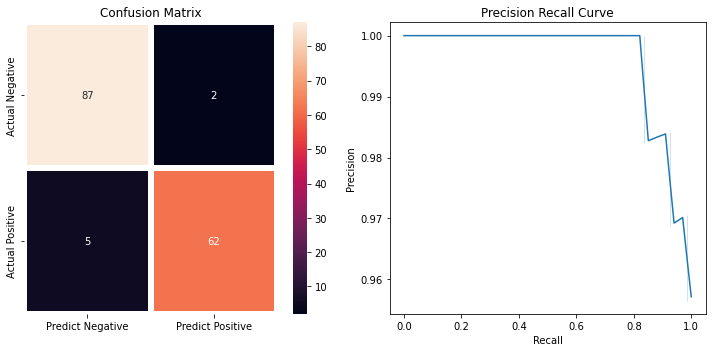

In [61]:
estimator.fit(X_train, y_train)
analyse(estimator, X_train, y_train, 'Training')

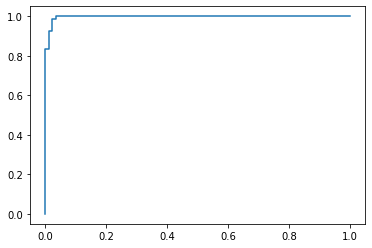

In [62]:
y_pred = estimator.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
plt.plot(fpr, tpr)

For Testing data
Correct Predictions: 42
False Positives Type I error: 0
False Negatives Type II error: 10
Accuracy: 0.8077
Precision: 1.0
Sensitivity: 0.6667
Specificity: 1.0
F1: 0.8
F_beta Recall Favoured 0.7143
Log_loss 6.6421
ROC AUC score 0.9636
PR_AUC:  0.9768


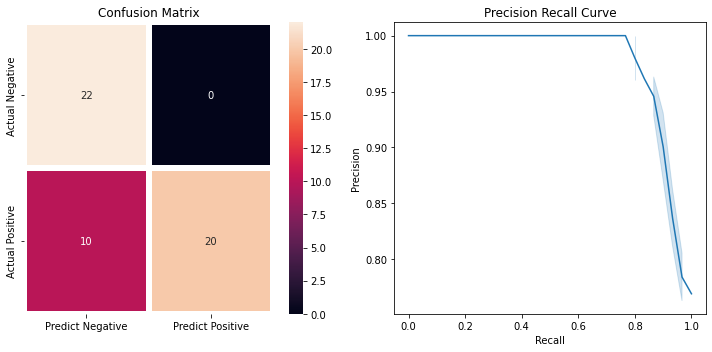

In [63]:
analyse(estimator, X_test, y_test, 'Testing')

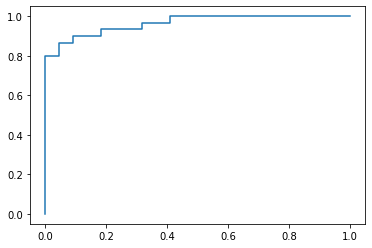

In [64]:
y_pred = estimator.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X_train, y_train, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Standardized: 80.96% (11.40%)


In [66]:
results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring = 'roc_auc')
print("Standardized ROC: %.2f std %.2f" % (results.mean(), results.std()))

Standardized ROC: 0.92 std 0.08


For Training data
Correct Predictions: 156
False Positives Type I error: 0
False Negatives Type II error: 0
Accuracy: 1.0
Precision: 1.0
Sensitivity: 1.0
Specificity: 1.0
F1: 1.0
F_beta Recall Favoured 1.0
Log_loss 0.0
ROC AUC score 1.0
PR_AUC:  1.0


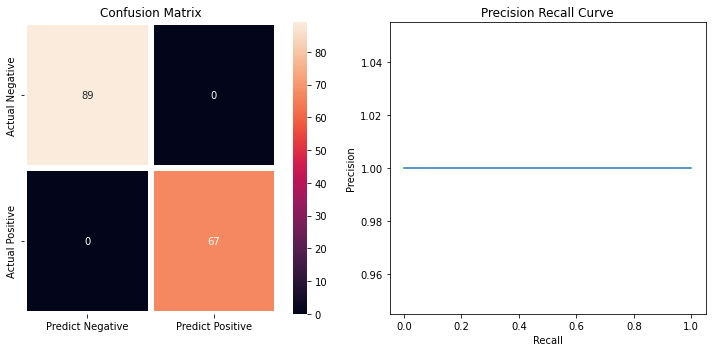

In [67]:
pipeline.fit(X_train, y_train)
analyse(pipeline, X_train, y_train, 'Training')

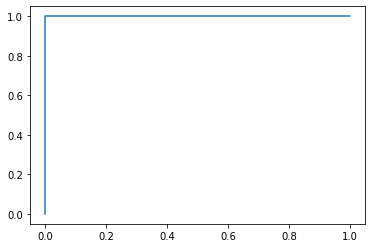

In [68]:
y_pred = pipeline.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
plt.plot(fpr, tpr)

For Testing data
Correct Predictions: 48
False Positives Type I error: 0
False Negatives Type II error: 4
Accuracy: 0.9231
Precision: 1.0
Sensitivity: 0.8667
Specificity: 1.0
F1: 0.9286
F_beta Recall Favoured 0.8904
Log_loss 2.6568
ROC AUC score 0.9758
PR_AUC:  0.9853


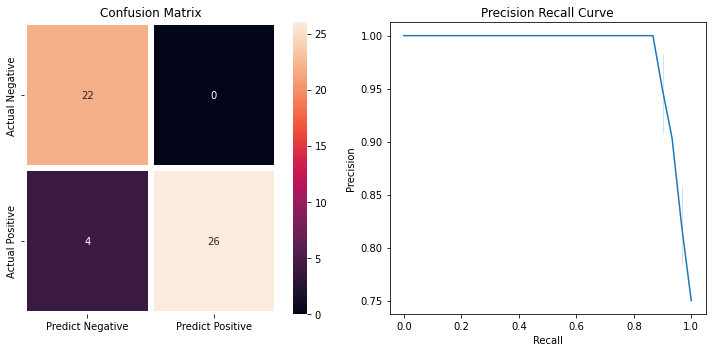

In [69]:
analyse(pipeline, X_test, y_test, 'Testing')

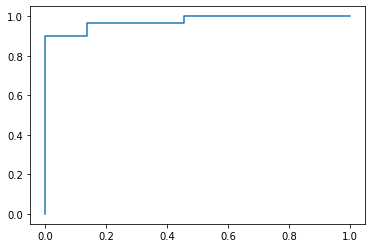

In [70]:
y_pred = pipeline.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)

In [71]:
# smaller model
def create_smaller():
	# create model
	model = Sequential()
	model.add(Dense(30, input_dim=60, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [53]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_smaller, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X_train, y_train, cv=kfold)
print("Smaller: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Smaller: 83.96% (6.01%)


In [54]:
results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring = 'roc_auc')
print("Smaller ROC: %.2f std %.2f" % (results.mean(), results.std()))

Smaller ROC: 0.92 std 0.09


For Training data
Correct Predictions: 156
False Positives Type I error: 0
False Negatives Type II error: 0
Accuracy: 1.0
Precision: 1.0
Sensitivity: 1.0
Specificity: 1.0
F1: 1.0
F_beta Recall Favoured 1.0
Log_loss 0.0
ROC AUC score 1.0
PR_AUC:  1.0


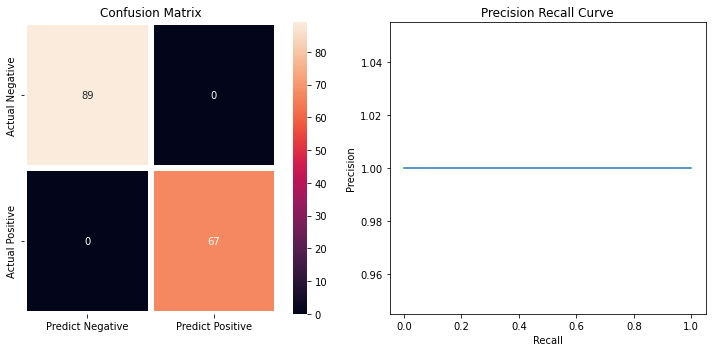

In [55]:
pipeline.fit(X_train, y_train)
analyse(pipeline, X_train, y_train, 'Training')

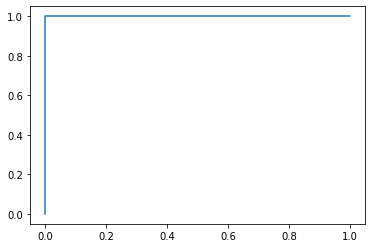

In [56]:
y_pred = pipeline.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
plt.plot(fpr, tpr)

For Testing data
Correct Predictions: 47
False Positives Type I error: 0
False Negatives Type II error: 5
Accuracy: 0.9038
Precision: 1.0
Sensitivity: 0.8333
Specificity: 1.0
F1: 0.9091
F_beta Recall Favoured 0.8621
Log_loss 3.321
ROC AUC score 0.9712
PR_AUC:  0.9827


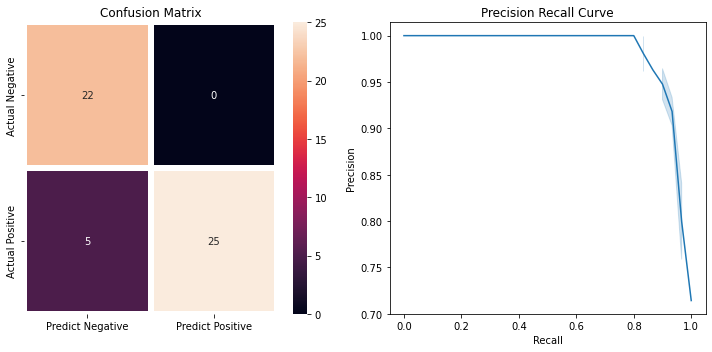

In [57]:
analyse(pipeline, X_test, y_test, 'Testing')

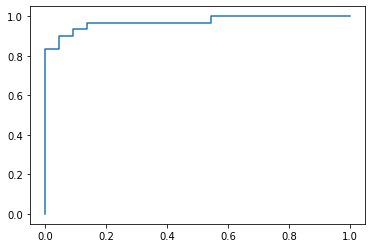

In [58]:
y_pred = pipeline.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)

In [35]:
# larger model
def create_larger():
	# create model
	model = Sequential()
	model.add(Dense(60, input_dim=60, activation='relu'))
	model.add(Dense(30, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [36]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_larger, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X_train, y_train, cv=kfold)
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Larger: 81.42% (8.03%)


In [37]:
results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring = 'roc_auc')
print("Larger ROC: %.2f std %.2f" % (results.mean(), results.std()))

Larger ROC: 0.89 std 0.10


For Training data
Correct Predictions: 156
False Positives Type I error: 0
False Negatives Type II error: 0
Accuracy: 1.0
Precision: 1.0
Sensitivity: 1.0
Specificity: 1.0
F1: 1.0
F_beta Recall Favoured 1.0
Log_loss 0.0
ROC AUC score 1.0
PR_AUC:  1.0


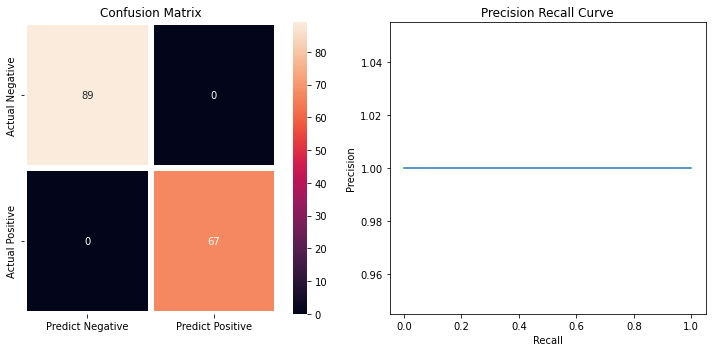

In [51]:
pipeline.fit(X_train, y_train)
analyse(pipeline, X_train, y_train, 'Training')

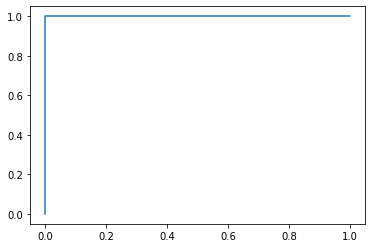

In [39]:
y_pred = pipeline.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
plt.plot(fpr, tpr)

For Testing data
Correct Predictions: 50
False Positives Type I error: 0
False Negatives Type II error: 2
Accuracy: 0.9615
Precision: 1.0
Sensitivity: 0.9333
Specificity: 1.0
F1: 0.9655
F_beta Recall Favoured 0.9459
Log_loss 1.3284
ROC AUC score 0.9848
PR_AUC:  0.9906


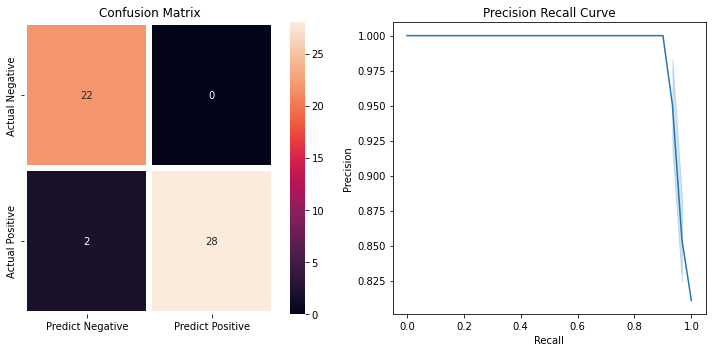

In [49]:
analyse(pipeline, X_test, y_test, 'Testing')

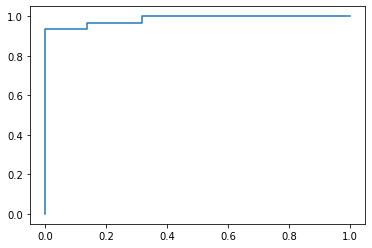

In [50]:
y_pred = pipeline.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)